In [1]:
from configs import cfg

cfg['input_dim'] = 301 # input dimension to LSTM
cfg['hidden_dim'] = 128 # hidden dimension for LSTM
cfg['output_dim'] = 1 # output dimension of the model
cfg['layers'] = 2 # number of layers of LSTM

cfg['dropout'] = 5e-3 # dropout rate between two layers of LSTM; useful only when layers > 1; between 0 and 1
cfg['bidirectional'] = True # True or False; True means using a bidirectional LSTM
cfg['batch_size'] = 120 # batch size of input
cfg['learning_rate'] = 1e-3 # learning rate to be used
cfg['L2_penalty'] = 1e-4 # weighting constant for L2 regularization term; this is a parameter when you define optimizer
cfg['epochs'] = 10 # number of epochs for which the model is trained
cfg['embed'] = False
cfg['score_range'] = 4
cfg['set_id'] = 6

In [2]:
import numpy as np
from preprocess import *
import pandas as pd

train_path = './essay_dataset/training_set_rel3.tsv'
training_data = load_training_set(train_path, cfg['set_id'])

glove_dict = load_dict('glove.840B.300d.pkl')

In [3]:
valid_path = './essay_dataset/valid_set.tsv'
valid_label_path = './essay_dataset/valid_sample_submission_2_column.csv'
valid_data = load_validation_set(valid_path, valid_label_path, cfg['set_id'])

In [4]:
training_data = process_scores(training_data, 'domain1_score')
valid_data = process_scores(valid_data, 'domain1_score')

In [5]:
from dataloader import *
from models import *
import time

model = LSTM_Score(cfg, True)
model = model.to(torch.device(cfg['device']))

criterion = nn.MSELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=cfg['learning_rate'], weight_decay=cfg['L2_penalty'])

train_indices = list(range(len(training_data)))
valid_indices = list(range(len(valid_data)))

print('ready')

ready


In [6]:
model.train()

LSTM_Score(
  (embed_linear): Linear(in_features=301, out_features=301, bias=True)
  (lstm): LSTM(301, 128, num_layers=2, batch_first=True, dropout=0.005, bidirectional=True)
  (bn): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=256, out_features=1, bias=True)
)

In [7]:
train_losses = []
val_losses = []
for epoch in range(cfg['epochs']):
    tloader = DataLoader(training_data, train_indices, cfg, glove_dict)
    vloader = DataLoader(valid_data, valid_indices, cfg, glove_dict)
    
    count = 0
    avg_loss = 0
    while tloader.has_next():
        train, label, lengths = tloader.get_next()
        #print(train.size())
        #print(label.size())
        #print(lengths.size())
        model.zero_grad()
        
        y = model(train, lengths)      
        
        loss = criterion(y*cfg['score_range'], label*cfg['score_range'])
        loss.backward()
        optimizer.step()

        count += 1
        avg_loss += loss.item()
        if count % 2 == 0:
            print("count = %d, loss = %.5f" %(count, avg_loss / 2))
            save_model(model, 'models/'+'s' + str(cfg['set_id']) + '_ba' +str(cfg['batch_size']) +'e' +  str(epoch + 1) + 'b' + str(count) + '.pt')
            train_losses.append(avg_loss/2)
            avg_loss = 0
        del train, label, y, loss
    
    count = 0
    avg_loss = 0
    with torch.no_grad():
        while vloader.has_next():
            train, label, lengths = vloader.get_next()
            y = model(train, lengths)
            loss = criterion(y*cfg['score_range'], label*cfg['score_range'])
            count += 1
            avg_loss += loss.item()
            del train, label, y, loss
    print('validation loss:', avg_loss / count)
    print('epoch finished:', epoch + 1)
    val_losses.append(avg_loss/count)
    

count = 2, loss = 1.78630
count = 4, loss = 2.03936
count = 6, loss = 1.25992
count = 8, loss = 0.89391
count = 10, loss = 0.80252
count = 12, loss = 0.72644
count = 14, loss = 0.59400
validation loss: 0.6501082897186279
epoch finished: 1
count = 2, loss = 0.54615
count = 4, loss = 0.56705
count = 6, loss = 0.52332
count = 8, loss = 0.47450
count = 10, loss = 0.42128
count = 12, loss = 0.56584
count = 14, loss = 0.44626
validation loss: 0.48413203954696654
epoch finished: 2
count = 2, loss = 0.34203
count = 4, loss = 0.38199
count = 6, loss = 0.35522
count = 8, loss = 0.31462
count = 10, loss = 0.30340
count = 12, loss = 0.31649
count = 14, loss = 0.28009
validation loss: 0.4560736298561096
epoch finished: 3
count = 2, loss = 0.27027
count = 4, loss = 0.25830
count = 6, loss = 0.33105
count = 8, loss = 0.26591
count = 10, loss = 0.23297
count = 12, loss = 0.24611
count = 14, loss = 0.26218
validation loss: 0.4015070080757141
epoch finished: 4
count = 2, loss = 0.23833
count = 4, loss =

In [8]:
np.save('val_loss_set6.npy', val_losses)
np.save('train_loss_set6.npy', train_losses)

In [8]:
from evaluation import QWK_score

vloader = DataLoader(valid_data, valid_indices, cfg, glove_dict)
count = 0
avg_loss = 0
MAE = 0
targets = []
preds = []
with torch.no_grad():
    while vloader.has_next():
        train, label, lenghts = vloader.get_next()
        y = model(train, lenghts)
        #y = y.permute(0, 2, 1)
        #print(label - y)
        
        loss = criterion(y*cfg['score_range'], label*cfg['score_range'])
        
        pred = np.round(y.cpu().numpy() * cfg['score_range'])
        target = np.round(label.cpu().numpy() * cfg['score_range'])

        pred = pred.flatten().astype(int)
        target = target.flatten().astype(int)
        
        targets.append(target)
        preds.append(pred)
        
        #print(targets[0])
        #print(preds[0])
        
        count += 1
        avg_loss += loss.item()
        MAE += (y-label).abs().mean().item()
        
        del train, label, y, loss
        
print('validation MSE:', avg_loss / count)
print('validation MAE:', MAE / count)
print('QWK Score:', QWK_score(np.asarray(targets).flatten(), np.asarray(preds).flatten(), min_rating = 0, max_rating = cfg['score_range']))

validation MSE: 0.4665324747562408
validation MAE: 0.1339450806379318
QWK Score: 0.6211297902160797


In [24]:
model = load_model(LSTM_Score, './models/s6_ba120e13b14.pt', cfg)
valid_indices = list(range(len(valid_data)))

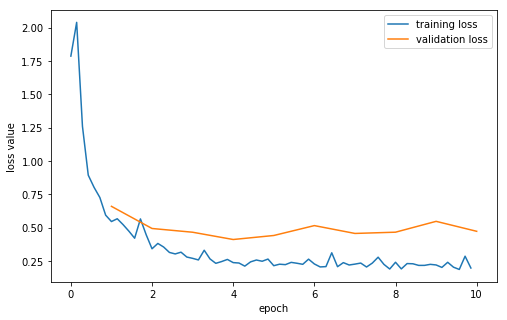

In [10]:
import matplotlib.pyplot as plt
import numpy as np


fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(np.arange(len(train_losses)) / (len(train_losses) // len(val_losses)),train_losses,label='training loss')
ax.plot(np.arange(1,len(val_losses)+1) ,np.array(val_losses) + 0.01,label='validation loss')

ax.set_xlabel('epoch')
ax.set_ylabel('loss value')
ax.legend()
plt.show()

In [14]:
targets

[array([4, 2, 2, 1, 3, 3, 3, 3, 3, 4, 2, 3, 3, 2, 3, 2, 2, 2, 3, 3, 4, 4,
        2, 3, 3, 4, 1, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3,
        3, 4, 2, 3, 1, 4, 2, 2, 2, 4, 2, 2, 3, 2, 0, 2, 3, 3, 4, 3, 2, 3,
        3, 2, 2, 3, 3, 3, 2, 3, 3, 3, 3, 3, 2, 3, 4, 3, 3, 3, 2, 3, 3, 4,
        2, 2, 2, 2, 4, 1, 2, 1, 2, 1, 3, 3, 3, 4, 4, 1, 3, 2, 3, 3, 2, 3,
        3, 3, 2, 4, 4, 2, 3, 3, 3, 3]),
 array([3, 3, 3, 4, 3, 4, 2, 3, 1, 3, 3, 3, 2, 2, 3, 4, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 4, 4, 4, 3, 3, 2, 4, 4, 1, 3, 4, 2, 1, 4, 3, 3, 3, 3, 3,
        4, 2, 2, 3, 3, 2, 1, 2, 1, 4, 3, 4, 3, 3, 3, 3, 3, 3, 3, 1, 3, 2,
        4, 2, 3, 2, 3, 3, 3, 2, 3, 3, 3, 4, 3, 2, 2, 4, 3, 3, 4, 2, 2, 3,
        2, 3, 2, 3, 3, 3, 3, 3, 2, 3, 4, 4, 4, 4, 4, 4, 1, 3, 3, 3, 3, 3,
        3, 3, 3, 1, 3, 2, 2, 2, 3, 2]),
 array([4, 3, 3, 3, 3, 4, 3, 3, 3, 3, 4, 3, 2, 3, 2, 1, 3, 1, 3, 4, 2, 2,
        3, 3, 2, 3, 3, 2, 2, 4, 2, 3, 3, 2, 2, 3, 2, 3, 2, 3, 3, 3, 3, 3,
        1, 1, 3, 1, 2, 2, 1, 3, 

In [13]:
preds

[array([3, 1, 1, 1, 0, 1, 1, 1, 3, 1, 1, 1, 1, 1, 3, 2, 1, 2, 1, 2, 1, 2,
        1, 1, 1, 1, 3, 1, 3, 1, 1, 1, 1, 1, 1, 2, 2, 3, 1, 2, 2, 2, 2, 2,
        2, 1, 1, 1, 2, 1, 1, 1, 3, 1, 2, 2, 2, 1, 2, 1, 3, 1, 3, 3, 1, 1,
        2, 2, 2, 1, 2, 3, 1, 1, 3, 2, 1, 0, 3, 1, 1, 1, 1, 1, 1, 2, 1, 0,
        3, 2, 3, 1, 1, 1, 2, 1, 2, 1, 1, 2, 3, 1, 1, 2, 1, 1, 1, 1, 1, 1,
        0, 3, 0, 1, 3, 1, 1, 2, 2, 3]),
 array([1, 1, 1, 1, 3, 1, 3, 2, 1, 3, 2, 2, 0, 1, 2, 2, 2, 1, 2, 3, 2, 2,
        1, 3, 2, 1, 0, 2, 1, 1, 3, 1, 1, 2, 1, 3, 1, 2, 2, 2, 3, 2, 3, 1,
        3, 1, 2, 1, 2, 1, 2, 1, 2, 1, 1, 2, 3, 3, 3, 2, 2, 2, 1, 1, 2, 1,
        1, 1, 1, 1, 0, 0, 2, 0, 1, 1, 2, 2, 1, 2, 3, 1, 1, 1, 1, 1, 2, 0,
        3, 1, 1, 3, 1, 3, 2, 3, 1, 1, 1, 1, 1, 0, 2, 2, 2, 1, 1, 1, 1, 3,
        0, 1, 1, 0, 2, 0, 1, 1, 1, 1]),
 array([3, 1, 1, 2, 1, 3, 3, 2, 2, 3, 1, 2, 1, 1, 1, 1, 0, 1, 2, 3, 2, 1,
        1, 0, 1, 0, 2, 1, 2, 0, 1, 1, 0, 2, 3, 3, 1, 2, 0, 3, 2, 2, 3, 2,
        2, 0, 3, 1, 1, 1, 1, 2, 

In [14]:
train_losses

[0.986262857913971,
 0.49855224788188934,
 0.37097203731536865,
 0.27103545516729355,
 0.3571770191192627,
 0.3371875286102295,
 0.3233692795038223,
 0.29358553886413574,
 0.27147065103054047,
 0.2570360377430916,
 0.32411572337150574,
 0.28441424667835236,
 0.2850971221923828,
 0.26060356199741364,
 0.3031533509492874,
 0.2800355404615402,
 0.2782614752650261,
 0.26905204355716705,
 0.2639346867799759,
 0.25397421419620514,
 0.2812599092721939,
 0.26381418853998184,
 0.2612764462828636,
 0.2880900800228119,
 0.22836203128099442,
 0.250477135181427,
 0.2888052612543106,
 0.23899435997009277,
 0.22949956357479095,
 0.28019827604293823,
 0.2299683392047882,
 0.20702288299798965,
 0.2745785564184189,
 0.2952907234430313,
 0.2964576780796051,
 0.2518981173634529,
 0.2789340913295746,
 0.2409902587532997,
 0.2847330942749977,
 0.2291913852095604,
 0.21149113029241562,
 0.24139761179685593,
 0.26308970153331757,
 0.20929107069969177,
 0.2225215658545494,
 0.2749718576669693,
 0.2275579795241

In [15]:
val_losses

[0.2725878618657589,
 0.3038000017404556,
 0.3743957653641701,
 0.4048277288675308,
 0.38204897195100784,
 0.3721608817577362,
 0.42862775176763535,
 0.3439985141158104,
 0.3559018224477768,
 0.35145624727010727,
 0.3409651964902878,
 0.36436453461647034,
 0.39821872115135193,
 0.3551393896341324,
 0.35657311230897903]